# Base de classification en Français 

    - Transformers : Summarization : 2 modèles --> 2 Résumés / Puis score de similarités de ces 2 résumés
    Noter que l'on peut faire aussi la similarité des textes (autre note ?) et non du résumé
    - Text classification sur une base de catégories "Presse" : sport - actaulités - économie - etc
    - Sentiment analysis : voir si le ton du texte est de même type 
    - Les 2 derniers classifier seronts utilisés en produit scalaire : Par Catégorie : texte1: note1 - texte2 : note2
    et donc sum(notes_par_catégorie) = sum(note1*note2) * 100 au bout (note sur 100)

In [2]:
import pandas as pd
import pke
import spacy
import torch
import stanza
import spacy_stanza
import warnings
import string
from gensim.models import KeyedVectors
import enchant    # Pour correction orthographique de synonymes
import numpy as np
import re
from transformers import pipeline
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import AutoModelWithLMHead, AutoTokenizer
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
tqdm.pandas()
warnings.filterwarnings("ignore")

C:\Users\stg-sdu\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\stg-sdu\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\stg-sdu\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


**Selection des modèles NLP : ici FRANCAIS**

In [3]:
# Chargement pour l'utilisation de Spacy  - Français
nlp_fr = spacy.load("fr_core_news_sm")

In [4]:
dico_spacy = {'fr':nlp_fr}   # 'en':nlp_en,'de':nlp_de,'es':nlp_es,'pl':nlp_pl  - POUR MEMOIRE
langues = ['en','fr','es','de','pl','ar','tr']

In [5]:
# Chargement du modèle Word2Vec pour utilisation de synonymes
model_gensim = KeyedVectors.load_word2vec_format("D:/Users/STG-SDU/Documents/NLP/Word2Vec.bin", binary=True, unicode_errors="ignore")

In [6]:
# Stopwords Français NLTK + Spacy 
stopWords = list(nlp_fr.Defaults.stop_words)
stopwords_fr = list(stopwords.words('french'))  
stopwords_fr = list(set(stopwords_fr + stopWords))
stopwds_lg = {'fr':stopwords_fr}

In [7]:
# correcteur orthographique pour validation des synonymes OPTIONNEL CAR NON NECESSAIRE
d = enchant.Dict("fr") 

**Sélection des modèles Transformers : Summary - Text Classification - Sentiment Analysis - Similarity**

In [8]:
# Modèles Transformers de Résumé (NB : Ne pas oublier d'ajouter la truncation pour tous les modèles, peut être source d'erreur)

summarizer1 = pipeline("summarization", model="moussaKam/barthez-orangesum-title", truncation = "only_first")
summarizer2 = pipeline("summarization", model="lincoln/mbart-mlsum-automatic-summarization", truncation = "only_first")

In [9]:
# Textes classification ou Zero shot classification (permet de chosiri nos propres thèmes)
text_clf1 = pipeline("text-classification", model = "lincoln/flaubert-mlsum-topic-classification", truncation = "only_first")   # 10 actégories, voir hugging face

# NB : BUG : zero_shot_clf = pipeline("zero-shot-classification", model="BaptisteDoyen/camembert-base-xlni") # download ne marche pas, donc manuel
nli_model = AutoModelForSequenceClassification.from_pretrained("BaptisteDoyen/camembert-base-xnli")
zero_tokenizer = AutoTokenizer.from_pretrained("BaptisteDoyen/camembert-base-xnli") 
text_clf2 = pipeline('zero-shot-classification', model=nli_model, tokenizer=zero_tokenizer,truncation = "only_first")
# ce modèle est un zero shot classification : catégories possibles choisies par mes soins (dans la presse)
candidate_labels = ['Sciences','Politique','Education','Actualités','Santé','Technologie','Société', 'Sport','Economie','Culture','International','Environnement']

In [10]:
# Sentiment Analysis
sentiment1 = pipeline("text-classification", model = 'moussaKam/barthez-sentiment-classification')

# ATTENTION CE MODELE n°2 SE DEFINIT SUR 4 CLASSES : mixed, positif, negatif, objectif
loaded_tokenizer = AutoTokenizer.from_pretrained('flaubert/flaubert_large_cased')
loaded_model = AutoModelForSequenceClassification.from_pretrained("DemangeJeremy/4-sentiments-with-flaubert")
sentiment2 = pipeline('sentiment-analysis', model=loaded_model, tokenizer=loaded_tokenizer)

Some weights of the model checkpoint at DemangeJeremy/4-sentiments-with-flaubert were not used when initializing FlaubertForSequenceClassification: ['transformer.position_ids']
- This IS expected if you are initializing FlaubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
def score_similarite(premise,hypothesis):
    # Compute a probability P(premise|hypothesis) : Score de similarités entre 2 titres - Par encodage
    # attention pour les textes : tensor trop long, pb résolu en utilisant : truncation = "only_first"
    x = zero_tokenizer.encode(premise, hypothesis,truncation = "only_first", return_tensors='pt')
    
    logits = nli_model(x)[0]
    entail_contradiction_logits = logits[:,::2]
    probs = entail_contradiction_logits.softmax(dim=1)
    prob_label_is_true = probs[:,0]
    return round(prob_label_is_true[0].tolist() * 100,2)

**Selection Data par langues**

In [12]:
data = pd.read_csv('train_data_prep_v1.csv')

In [13]:
data

,pair_id,pair_lang,source_url_1,publish_date_1,source_url_2,publish_date_2,title_1,text_1,meta_description_1,meta_keywords_1,...,text_2,meta_description_2,meta_keywords_2,Geography,Entities,Time,Narrative,Overall,Style,Tone
0,1484084337_1484110209,en_en,https://www.washingtonpost.com,Wed Jan 1 00:00:00 2020,https://www.washingtonpost.com,Wed Jan 1 00:00:00 2020,Virginia man arrested in fatal DUI crash in We...,"MARTINSBURG, W.Va. — A suspected drunken drive...",Police in West Virginia say a suspected drunke...,"['Highway Fatal-DUI-West Virginia', 'Martinsbu...",...,"PORT-AU-PRINCE, Haiti — Haitian President Jove...",Haitian President Jovenel Moïse has broken wit...,"['CB-Haiti-Political Turmoil', 'Jean', 'Haiti'...",4.0,4.000000,1.000000,4.000000,4.000000,1.666667,2.000000
1,1484396422_1483924666,en_en,https://www.stlucianewsonline.com,Wed Jan 1 21:17:15 2020,https://www.thestar.com,Wed Jan 1 00:00:00 2020,Guyana: Three injured after car crashes into u...,Share This On:\n\nPin 11 Shares\n\n(NEWS ROOM ...,-,[''],...,BERLIN - A fire at a zoo in western Germany in...,BERLIN - A fire at a zoo in western Germany in...,"['smg2_world', 'smg_europe', 'smg2_news']",4.0,4.000000,1.000000,4.000000,3.666667,1.666667,1.333333
2,1484698254_1483758694,en_en,https://www.teaparty.org,NaN,https://www.timesofisrael.com,NaN,Trump Brings In 2020 At Mar-a-Lago: ‘We’re Goi...,(Breitbart) – President Donald Trump welcomed ...,NaN,[''],...,"PALM BEACH, United States — US President Donal...",US president says response to rioting by pro-I...,[''],1.0,2.000000,1.000000,2.333333,2.333333,1.000000,1.333333
3,1576314516_1576455088,en_en,https://gadgets.ndtv.com,NaN,https://gadgets.ndtv.com,NaN,Zomato Buys Uber's Food Delivery Business in I...,Uber has sold its online food-ordering busines...,Zomato on Tuesday announced it has acquired Ub...,['zomato uber eats business acquisition india ...,...,Rapid digitisation and growth in both online b...,The report by Google and Boston Consulting Gro...,['indian online food delivery market to hit us...,1.0,2.333333,2.666667,1.666667,2.000000,1.666667,1.666667
4,1484036253_1483894099,en_en,https://news.yahoo.com,Wed Jan 1 08:57:59 2020,https://www.channelnewsasia.com,NaN,"India approves third moon mission, months afte...",BENGALURU (Reuters) - India has approved its t...,India has approved its third lunar mission mon...,[''],...,BANGALORE: India plans to make a fresh attempt...,India plans to make a fresh attempt to land an...,"['India', 'space']",1.0,1.250000,1.000000,1.250000,1.250000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4959,1586195445_1598778991,tr_tr,http://www.haberler.com,NaN,https://www.haberler.com,NaN,"BM, Aden'de 2 bini aşkın iç göçmenin selden za...","BM, Aden'de 2 bini aşkın iç göçmenin selden za...","Birleşmiş Milletler (BM), 2 bini aşkın iç göçm...","['Birleşmiş Milletler', 'Twitter', 'Yemen', 'G...",...,BM'den Yemen'de kadınların doğumda ölüm riski ...,BİRLEŞMİŞ Birleşmiş Milletler (BM) dünyanın en...,"['Birleşmiş Milletler', 'Yemen', 'Güncel', 'Ha...",1.0,2.000000,2.000000,4.000000,3.000000,1.000000,1.000000
4960,1590915424_1590940388,tr_tr,https://www.haberler.com,NaN,https://www.aksam.com.tr,NaN,Kovid-19'dan dolayı La Liga kulüplerinde hayat...,Kovid-19'dan dolayı La Liga kulüplerinde hayat...,Yeni tip koronavirüs (Kovid-19) salgınının eko...,"['Real Madrid', 'İspanya', 'La Liga', 'Futbol'...",...,Yeni tip koronavirüs (Kovid-19) salgınının eko...,Yeni tip koronavirüs (Kovid-19) salgınının eko...,"['İspanya 1. Futbol Ligi', 'la liga', 'koronav...",1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4961,1526157103_1492737005,tr_tr,http://www.samanyoluhaber.com,Thu Feb 20 10:47:10 2020,https://www.fotomac.com.tr,Sun Jan 12 00:00:00 2020,Saray da çare olmadı: 'Borca boğulan dev kulüp...,\n\n\n\n\n\n\n\nİflas noktasındaki kulüplerin ...,SARAY DA ÇARE OLMADI: 'BORCA BOĞULAN DEV KULÜP...,"['Saray', 'da', 'çare', 'olmadı:', ""'Borca""

In [14]:
# remémorer numéro de ligne - compléter les Nan
data['ligne'] = data.index
data = data.fillna('')

In [15]:
# séparation des datasets, le dernier étant à traduire en plus
francais = data.loc[data.pair_lang == 'fr_fr',['ligne','title_1','title_2','text_1','text_2','Geography', 'Entities',
       'Time', 'Narrative', 'Overall', 'Style', 'Tone']].reset_index(drop=True)

**Tests divers et Fonctions nécessaires**

In [16]:
# Résumés
print(summarizer1(francais.text_1[3])[0]['summary_text'])
print(summarizer1(francais.text_2[3])[0]['summary_text'])

Coronavirus : le chanteur et chanteur camerounais Manu Dibango est décédé
Coronavirus : l'Afrique pleure Manu Dibango victime du coronavirus


In [17]:
print(summarizer2(francais.text_1[3])[0]['summary_text'])
print(summarizer2(francais.text_2[3])[0]['summary_text'])

Atteint par le covid-19, l'artiste camerounais est mort mardi matin des suites de la maladie, à l'âge de 86 ans.
En l'espace de quelques jours, deux piliers de la musique du continent sont morts des suites du coronavirus.


In [18]:
# Fonction de calcul du score (produit scalaire) pour résultats de classifaction
def fonction_produit_dotcom(liste_categor, dico_scores1,dico_scores2):
    """"dico scores sont les résultats obtenus pour chaque catégorie des textes 1 et 2"""
    result = 0.0
    for cat in liste_categor:
        result += round(dico_scores1[cat] * dico_scores2[cat],4)
    return result * 100

In [19]:
# transformation des résultats du transformer type1
def transform_text_clf1(liste_dico):
    res = {}
    for dic in liste_dico:
        res[dic['label']] = dic['score']
    return res

In [20]:
# transformation des résultats du transformer type2
def transform_text_clf2(liste_cat,liste_sc):
    res = {}
    for i in range(len(liste_cat)):
        res[liste_cat[i]] = liste_sc[i]
    return res

In [21]:
# Tests
liste_categories = ['Culture', 'Politique', 'Economie','Education','Technologie','Justice','Sport', 'Environement', 'Societe', 'Opinion']
scores1 = transform_text_clf1(text_clf1(francais.text_1[3],return_all_scores=True)[0])
scores2 = transform_text_clf1(text_clf1(francais.text_2[3],return_all_scores=True)[0])
print(scores1)
print(scores2)
print(fonction_produit_dotcom(liste_categories, scores1,scores2))

{'Culture': 0.8504540324211121, 'Economie': 0.016547389328479767, 'Education': 0.001298199757002294, 'Environement': 0.004739914555102587, 'Justice': 0.005226531997323036, 'Opinion': 0.006533971522003412, 'Politique': 0.010109643451869488, 'Societe': 0.09446243196725845, 'Sport': 0.0021014309022575617, 'Technologie': 0.008526437915861607}
{'Culture': 0.27542635798454285, 'Economie': 0.01746021956205368, 'Education': 0.014121603220701218, 'Environement': 0.13672736287117004, 'Justice': 0.00473390007391572, 'Opinion': 0.11063723266124725, 'Politique': 0.007973399013280869, 'Societe': 0.13605180382728577, 'Sport': 0.14063476026058197, 'Technologie': 0.1562332808971405}
25.039999999999996


In [22]:
# Tests
classes = text_clf2(francais.text_1[3], candidate_labels)
scores1 = transform_text_clf2(classes['labels'],classes['scores'])
classes2 = text_clf2(francais.text_2[3], candidate_labels)
scores2 = transform_text_clf2(classes2['labels'],classes2['scores'])
print(fonction_produit_dotcom(candidate_labels, scores1,scores2))

9.45


In [23]:
# Tests sentiment analysis
liste_labels = ['Negative','Positive']
scores1 = transform_text_clf1(sentiment1(francais.text_1[3],return_all_scores=True)[0])
scores2 = transform_text_clf1(sentiment1(francais.text_2[3],return_all_scores=True)[0])
print(scores1)
print(scores2)
print(fonction_produit_dotcom(liste_labels, scores1,scores2))

{'Negative': 0.0010380345629528165, 'Positive': 0.9989619255065918}
{'Negative': 0.0012133318232372403, 'Positive': 0.9987866282463074}
99.77000000000001


In [24]:
# ATTENTION CE MODELE SE DEFINIT SUR 4 CLASSES : mixed, positif, negatif, objectif
liste_sentiments = ['MIXED','NEGATIVE','POSITIVE','OBJECTIVE']
scores1 = transform_text_clf1(sentiment2(francais.title_1[3],return_all_scores=True)[0])
scores2 = transform_text_clf1(sentiment2(francais.title_2[3],return_all_scores=True)[0])
scores3 = transform_text_clf1(sentiment2(francais.text_1[3],return_all_scores=True)[0])
scores4 = transform_text_clf1(sentiment2(francais.text_2[3],return_all_scores=True)[0])
print(fonction_produit_dotcom(liste_sentiments, scores1,scores2))
print(fonction_produit_dotcom(liste_sentiments, scores3,scores4))

27.889999999999997
41.05


In [25]:
# TESTS SCORES DE SIMILARITES : Titres, Textes complets (attention Truncation ...)
print(score_similarite(francais.title_1[3],francais.title_2[3]))
print(score_similarite(francais.text_1[3],francais.text_2[3]))
print(score_similarite(summarizer1(francais.text_1[0])[0]['summary_text'],summarizer1(francais.text_2[0])[0]['summary_text']))
print(score_similarite(summarizer2(francais.text_1[0])[0]['summary_text'],summarizer2(francais.text_2[0])[0]['summary_text']))

69.1
95.88
0.24
0.51


In [26]:
# Essais de synonymies à utiliser pour sorties PKE, termes prinicpaux
syns = model_gensim.most_similar("décès", topn=10)
syns

[('décéder', 0.6537684202194214),
 ('décé', 0.5344727039337158),
 ('deces', 0.5302326679229736),
 ('survenir', 0.5168903470039368),
 ('accident', 0.5078858137130737),
 ('surmortalité', 0.4999918043613434),
 ('obsèque', 0.49124661087989807),
 ('invalidité', 0.4891868233680725),
 ('mortalité', 0.48478570580482483),
 ('défunt', 0.48272594809532166)]

In [27]:
# Fonctions de summarization 
def summarization(texte):
    return summarizer1(texte)[0]['summary_text'], summarizer2(texte)[0]['summary_text']

In [28]:
dico_classifiers = {'text_clf1': 'score_classif1','text_clf2':'score_classif2','sentiment1':'score_sentiment1',
                    'sentiment2': 'score_sentiment2'}
dico_categories = {'text_clf1': liste_categories,'text_clf2':candidate_labels,'sentiment1':liste_labels,
                    'sentiment2': liste_sentiments}

In [29]:
# Fonctions de classification et sentiment analysis
def classification(texte,clf):
    # assume nms des classifiers et methode de transformation
    if clf == "text_clf1":
        try:
            scores = transform_text_clf1(text_clf1(texte,return_all_scores=True)[0])
        except:
            return 'error'
        else:
            return scores
    elif clf == "text_clf2":                                 
        try:
            classes = text_clf2(texte,dico_categories['text_clf2'])
        except:
            return 'error'
        else:
            return transform_text_clf2(classes['labels'],classes['scores'])                          
    elif clf == "sentiment1":
        try:
            scores = transform_text_clf1(sentiment1(texte,return_all_scores=True)[0])
        except:
            return 'error'
        else:
            return scores
    elif clf == "sentiment2":
        try:
            scores = transform_text_clf1(sentiment2(texte,return_all_scores=True)[0])
        except:
            return 'error'
        else:
            return scores
    else:
        return 'error'

In [30]:
# Prétraitement NLP pour PKE : suppression des mots de moins de 2 lettres non numériques
def supp_moins_2_lettres_stopwords(phrase,stopwd):
    temp = phrase.split(' ')
    res = ''
    for mot in temp:
        if mot not in stopwd and (len(mot)>2 or (len(mot)>0 and mot[0] in ['0','1','2','3','4','5','6','7','8','9'])):
            res += mot + ' '
    return res[:-1]

In [31]:
# Prétraitement NLP pour PKE : suppression des traits d'union(regroupe)/ des apostrophes / ponctuations
def modif(texte,stopmots):
    # modifications simples des textes : ponctuations, petits mots, stopwords (à faire pour entités et pke textes)
    texte=re.sub('\'',' ',texte)   # suppression apostrophe
    texte=re.sub('-','',texte)    # suppression trait union
    regex = re.compile('[%s]' % re.escape(string.punctuation)) # suppression de toutes les ponctuations
    texte=regex.sub(' ',texte)
    texte = supp_moins_2_lettres_stopwords(texte,stopmots)
    return texte

In [32]:
# Ajout des synonymes (existants en orthographe) à la suite de l'analyse pke
def ajout_synonymes(mot, correct_ortho = True):
    # on ajoute les 10 premiers synonymes existants, on vérifie orthographe (optionnel)
    syns = model_gensim.most_similar(mot,topn = 20)
    if correct_ortho == True:
        res = []
        for m in syns:
            if d.check(m[0]):   #  il y a le mot et son pourcentage d'importance
                res.append(m)
        syns = res
    return syns[:10]

Quelle est la bonne méthodologie à appliquer PKE ??? : Noms Ok - Verbes ? - Adjectifs ? - Noms propres ?
Quelle quantité de mots prendre ?
Ne pas noter les titres seuls ? : trop peu de mots !  Et du coup note peut être forte avec un seul mot !
Supprimer en en-tête les stopwords, ponctuation, les apostrophes - AUTRES ?????

In [33]:
# Choix des paramètres de la méthode : A revoir ?
methode1 = {"NOUN", "PROPN", "ADJ","VERB"}
methode2 = {"NOUN", "PROPN", "ADJ"}
nb_mots = {'meth1': 30, 'meth2':50}

In [34]:
# PKE : Analyse des termes principaux dans les textes et titres 
# Problème 
def transformation_pke_results(res1,res2, correct_ortho = True):
    """
    Transformation des resultats de PKE : Pb bigramme peuvent ne pas être ds les 2 textes mais 1 mot seulement
    liste de clés et dictionnaires de valeurs, bigrammes jouera ainsi de maniere coefficientée 
    Exemple : fuite eau:0.05 --> 3 mots au final : fuite, eau, fuite eau : 0.05
    De plus on ajoute les synonymes issus de gensim en les coefficiant et vérifiant que cela """
    
    liste1 = []; liste2 = [] ; dico1 = {}; dico2 = {}
    for elt in res1:
        liste1.append(elt[0])
        dico1[elt[0]] = round(elt[1],3)
        if ' ' in elt[0]:    # bigramme dans ce cas, ajout des 2 mots
            liste = elt[0].split(' ')
            for mot in liste:
                liste1.append(mot)
                dico1[mot] = round(elt[1],3)
                try:
                    synonyms = ajout_synonymes(mot,correct_ortho = correct_ortho)
                except:
                    pass
                else:
                    for syn in synonyms:
                        liste1.append(syn[0])   # Ajout du mot 
                        dico1[syn[0]] = round(elt[1] * syn[1], 3)  # poids considéré
                    
    for elt in res2:
        liste2.append(elt[0])
        dico2[elt[0]] = round(elt[1],3)
        if ' ' in elt[0]:
            liste = elt[0].split(' ')
            for mot in liste:
                liste2.append(mot)
                dico2[mot] = round(elt[1],3)
                try:
                    synonyms = ajout_synonymes(mot,correct_ortho = correct_ortho)
                except:
                    pass
                else:
                    for syn in synonyms:
                        liste2.append(syn[0])   # Ajout du mot 
                        dico2[syn[0]] = round(elt[1] * syn[1], 3)  # poids considéré
    
    # similarites entre les 2 listes issus de pke avec poids
    sim = 0
    for elt in liste1:
        if elt in liste2:
            sim += (dico1[elt] + dico2[elt])/2
    return sim

In [35]:
def entites_communes(nlp,text1,text2):
    """"
    Cette première fonction ne regarde que les entités communes : personnes, dates, groupe, localisations
    Elle sera appliquée aux textes et aux titres et cumulé : si cumul en titre et texte : compte double !"""
    
    doc1 = nlp(text1)
    doc2 = nlp(text2)
    nb_commun_ent = 0; liste_commun_ent = []
    nb_commun_geo = 0; liste_commun_geo = []
    nb_commun_dat = 0; liste_commun_dat = []
    
    if len(doc1.ents)>0 and len(doc2.ents)>0:
        liste1 = []; dico1 = {}
        for elt in doc1.ents:
            if elt.label_ == 'PERSON' and ' ' in elt.text:
                mots = elt.text.split(' ')
                for mot in mots:
                    if mot not in liste1:
                        liste1.append(mot)
                        dico1[mot] = elt.label_
            elif elt.label_ in ['LOC','ORG','GPE','DATE','TIME']:
                if elt.text not in liste1:
                    liste1.append(elt.text)
                    dico1[elt.text] = elt.label_
        liste2 = []
        for elt in doc2.ents:
            if elt.label_ == 'PERSON' and ' ' in elt.text:
                mots = elt.text.split(' ')
                for mot in mots:
                    if mot not in liste2:
                        liste2.append(mot)
            elif elt.label_ in ['LOC','ORG','GPE','DATE','TIME']:
                if elt.text not in liste2:
                    liste2.append(elt.text)
        
        # points communs des listes        
        for elt in liste1:
            if elt in liste2:
                if dico1[elt] == 'LOC':
                    nb_commun_geo += 1
                    liste_commun_geo.append(elt)
                elif dico1[elt] in ['DATE','TIME']:
                    nb_commun_dat += 1
                    liste_commun_dat.append(elt)
                else:
                    nb_commun_ent += 1
                    liste_commun_ent.append(elt)
                    
    return nb_commun_ent, liste_commun_ent,nb_commun_geo, liste_commun_geo,nb_commun_dat, liste_commun_dat

In [36]:
def Creation_features_comparaison(df,langue, test_position = [methode1,methode2]):
    """Création des notes pour classification ensuite"""
    
    resultats = pd.DataFrame(columns = ['summary1_text1','summary2_text1','summary1_text2','summary2_text2',
            'nb_entites_idem','nb_lieux_idem', 'nb_dates_idem','entites_idem','lieux_idem','dates_idem',
            'score_similarite_titres','score_similarite_resume1','score_similarite_resume2','score_classif1','score_classif2',
            'score_sentiment1','score_sentiment2','meth1_similarites','meth2_similarites'])
    
    # initialisation de la langue stanza
    stanza.download(langue)
    nlp_stanza = spacy_stanza.load_pipeline(langue)
    stopmts = stopwds_lg[langue]
    if langue in dico_spacy.keys():
        nlp_spacy = dico_spacy[langue]
    else:
        nlp_spacy = None
        
    for i in tqdm(range(len(df))):
        dico_res = {}
        
        # Summary et comparatifs 
        dico_res['summary1_text1'],dico_res['summary2_text1'] = summarization(df.text_1[i])
        dico_res['summary1_text2'],dico_res['summary2_text2'] = summarization(df.text_2[i])
        dico_res['score_similarite_titres'] = score_similarite(df.title_1[i],df.title_2[i])
        dico_res['score_similarite_resume1'] = score_similarite(dico_res['summary1_text1'],dico_res['summary1_text2'])
        dico_res['score_similarite_resume2'] = score_similarite(dico_res['summary2_text1'],dico_res['summary2_text2'])
        
        # analyse de textes classification et de sentiments
        texte1 = df.title_1[i] + ' ' + df.text_1[i]
        texte2 = df.title_2[i] + ' ' + df.text_2[i]
        if len(texte1)>0 and len(texte2)>0:
            for classifier in dico_classifiers.keys():
                scores1 = classification(texte1,classifier)
                scores2 = classification(texte2,classifier)
                if scores1 != 'error' and scores2 != 'error':
                    dico_res[dico_classifiers[classifier]] = fonction_produit_dotcom(dico_categories[classifier], scores1,scores2)
                else:
                    scores1 = classification(df.title_1[i],classifier)
                    scores2 = classification(df.title_2[i],classifier)
                    if scores1 != 'error' and scores2 != 'error':
                        dico_res[dico_classifiers[classifier]] = fonction_produit_dotcom(dico_categories[classifier], scores1,scores2)
                    else:
                        dico_res[dico_classifiers[classifier]] = None
                
        # pré traitement des textes pour entités et PKE
        texte1 = modif(texte1, stopmts)
        texte2 = modif(texte2, stopmts)
        
        # ENTITES COMMUNES : on tient compte des bigrammes Noms qui posent erreurs ex: Joe Biden et Biden 
        # Ici, on considère mieux le CUMUl titres et Textes avec une pondération double pour le titre 
        # Il faut aussi enlever les petits mots donc pré-traitement en texte
        
        nb_ent1,list_ent1,nb_geo1,list_geo1,nb_dat1,list_dat1 = entites_communes(nlp_stanza,df.title_1[i],df.title_2[i])
        nb_ent2,list_ent2,nb_geo2,list_geo2,nb_dat2,list_dat2 = entites_communes(nlp_stanza,df.text_1[i],df.text_2[i])
        if nlp_spacy != None:
            nb_ent3,list_ent3,nb_geo3,list_geo3,nb_dat3,list_dat3 = entites_communes(nlp_spacy,df.title_1[i],df.title_2[i])
            nb_ent4,list_ent4,nb_geo4,list_geo4,nb_dat4,list_dat4 = entites_communes(nlp_spacy,df.text_1[i],df.text_2[i])
        else:
            nb_ent3,list_ent3,nb_geo3,list_geo3,nb_dat3,list_dat3 = (0,[],0,[],0,[])
            nb_ent4,list_ent4,nb_geo4,list_geo4,nb_dat4,list_dat4 = (0,[],0,[],0,[])
        dico_res['nb_entites_idem'] = nb_ent1 * 2 + nb_ent2 + nb_ent3 * 2 + nb_ent4
        dico_res['nb_lieux_idem'] = nb_geo1  * 2 + nb_geo2 + nb_geo3  * 2 + nb_geo4
        dico_res['nb_dates_idem'] = nb_dat1 * 2 + nb_dat2 + nb_dat3 * 2 + nb_dat4
        # fusion des listes en supprimant les doublons
        dico_res['entites_idem'] = list(set(list_ent1+list_ent2+ list_ent3+list_ent4))
        dico_res['lieux_idem'] = list(set(list_geo1+list_geo2+list_geo3+list_geo4))
        dico_res['dates_idem'] = list(set(list_dat1+list_dat2+list_dat3+list_dat4))
        
        for j,meth in enumerate(test_position):
            nom ='meth'+str(j+1)
            nb_mots_meth = nb_mots[nom]
            if len(texte1)>0 and len(texte2)>0:
                extractor = pke.unsupervised.TopicRank()
                extractor.load_document(input=texte1,language=langue,normalization="stemming")
                extractor.candidate_selection(pos=meth)
                extractor.candidate_weighting()
                keyphrases3 = extractor.get_n_best(n=nb_mots_meth)
                extractor = pke.unsupervised.TopicRank()
                extractor.load_document(input=texte2,language=langue,normalization="stemming")
                extractor.candidate_selection(pos=meth)
                extractor.candidate_weighting()
                keyphrases4 = extractor.get_n_best(n=nb_mots_meth)
                dico_res[nom+'_similarites'] = round(100*transformation_pke_results(keyphrases3,keyphrases4),1)
            else:
                dico_res[nom+'_similarites'] = 'Error'
        
        resultats.loc[len(resultats)] = dico_res
        
    newdf = pd.concat([df,resultats],axis=1)
    return newdf

In [37]:
# Attention probleme au 16e index non identifié ...
similarites = Creation_features_comparaison(francais,'fr')

2021-12-19 07:15:04 INFO: Downloading default packages for language: fr (French)...
2021-12-19 07:15:07 INFO: File exists: C:\Users\stg-sdu\stanza_resources\fr\default.zip.
2021-12-19 07:15:15 INFO: Finished downloading models and saved to C:\Users\stg-sdu\stanza_resources.
2021-12-19 07:15:15 INFO: Loading these models for language: fr (French):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| pos       | gsd     |
| lemma     | gsd     |
| depparse  | gsd     |
| ner       | wikiner |

2021-12-19 07:15:15 INFO: Use device: cpu
2021-12-19 07:15:15 INFO: Loading: tokenize
2021-12-19 07:15:15 INFO: Loading: mwt
2021-12-19 07:15:15 INFO: Loading: pos
2021-12-19 07:15:15 INFO: Loading: lemma
2021-12-19 07:15:16 INFO: Loading: depparse
2021-12-19 07:15:16 INFO: Loading: ner
2021-12-19 07:15:18 INFO: Done loading processors!


  0%|          | 0/72 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (672 > 512). Running this sequence through the model will result in indexing errors
Your max_length is set to 200, but you input_length is only 122. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 200, but you input_length is only 179. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 200, but you input_length is only 150. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your min_length is set to 10, but you input_length is only 2. You might consider decreasing min_length manually, e.g. summarizer('...', min_length=10)
Your max_length is set to 100, but you input_length is only 2. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 200, but you input_length i

In [38]:
similarites.to_csv('corpus_fr_notes.csv')

## Classification Sklearn Pycaret

In [39]:
import pandas as pd
francais = pd.read_csv('corpus_fr_notes.csv',index_col=0)

In [40]:
# attention certains textes ne sont pas fournies et donc mis en "Error" : A supprimer donc
# On pourrait éventuellement tester en ne prenant plus les meth similarités ds les predicteurs
francais = francais[francais.meth1_similarites!='Error']

In [41]:
francais = francais.round({'Geography':0, 'Entities':0,'Time':0, 'Narrative':0, 'Overall':0, 'Style':0, 'Tone':0})

In [42]:
partiel = francais[['Geography', 'Entities','Time', 'Narrative', 'Overall', 'Style', 'Tone']].astype('int32')

In [43]:
francais = pd.concat([francais[['ligne', 'title_1', 'title_2', 'text_1', 'text_2','summary1_text1', 'summary2_text1', 'summary1_text2', 'summary2_text2']],
        partiel,francais[['nb_entites_idem', 'nb_lieux_idem', 'nb_dates_idem', 'entites_idem','dates_idem', 'score_similarite_titres',
       'score_similarite_resume1', 'score_similarite_resume2','score_classif1', 'score_classif2', 'score_sentiment1',
       'score_sentiment2', 'meth1_similarites', 'meth2_similarites']]],axis=1)

In [44]:
francais

,ligne,title_1,title_2,text_1,text_2,summary1_text1,summary2_text1,summary1_text2,summary2_text2,Geography,...,dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,meth1_similarites,meth2_similarites
0,2317,L'euphorie du marché résistera-t-elle au coron...,"De nombreux médecins toujours sans masques, ma...",Le cap du million de ventes a été dépassé l'an...,"Stocks réduits ou distribués au ""compte-goutte...",Immobilier : le cap du million de ventes dépas...,L'empressement des acheteurs à devenir proprié...,Coronavirus : les soignants manquent toujours ...,Les soignants français manquent toujours de ma...,1,...,[],3.26,0.24,0.51,5.90,8.42,0.04,28.06,164.8,249.0
1,2318,Clarenceville: Alexandre et Ilana Dupont n’iro...,COVID-19 : le fédéral donnera 2 000 $ par mois...,SPORTS – La majorité des activités sportives d...,"Cette nuit, la Chambre des communes a adopté l...",Coronavirus : le Canada n'enverrait pas ses at...,La majorité des activités sportives de la plan...,Canada : 82 G d'aide d'urgence pour les Canadiens,"Cette nuit, la Chambre des communes a adopté l...",3,...,[],0.56,0.35,0.69,0.10,9.02,99.92,31.29,160.8,84.6
2,2319,Deux retraités matanais sont coincés en Équateur,"L'opération de rapatriement est un «fiasco», d...","Deux Matanais, Hélène Gagnon et Clarence Bouff...",Sarah Mahu est coincée au Pérou. Elle a réussi...,Coronavirus : des Canadiens coincés en Équateu...,"Un couple de Québécois, coincés en Équateur, a...",Coronavirus : des Québécois coincés au Pérou q...,Un mois après la proclamation de l'état d'urge...,3,...,[],5.87,0.17,3.72,34.85,8.48,98.21,25.93,136.0,234.2
3,2320,Coronavirus : le musicien et chanteur cameroun...,"L'Afrique pleure Manu Dibango, victime du coro...","Atteint par le covid-19, l’artiste camerounais...","L'Afrique pleure Manu Dibango, victime du coro...",Coronavirus : le chanteur et chanteur cameroun...,"Atteint par le covid-19, l'artiste camerounais...",Coronavirus : l'Afrique pleure Manu Dibango vi...,"En l'espace de quelques jours, deux piliers de...",1,...,[],69.10,54.08,73.07,35.05,9.03,99.62,30.55,148.4,134.8
4,2321,La MRC de Marguerite-D’Youville prend les gran...,Le travail inquiétant des femmes dans la pandé...,C’est dans le cadre de la crise générée par la...,"Pour la version anglais, cliquez ici. / For th...",Crise de la Covid-19 : la MRC de Marguerite-D’...,Dans le cadre de la crise générée par la COVID...,Coronavirus : les femmes sont nettement plus i...,Pour lutter contre la pauvreté et les inégalit...,3,...,[],0.54,6.57,7.90,5.27,8.97,99.97,40.37,107.4,117.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,4879,Maroc : la location aux touristes interdite,Maroc : la justice ouvre une enquête pour viol...,Les forces de l’ordre effectuent des inspectio...,Suite aux violations du confinement dans les v...,Maroc : la police inspecte les appartements de...,Les forces de l'ordre effectuent des inspectio...,Confinement : le parquet de Tanger ouvre une e...,Suite aux violations du confinement dans les v...,2,...,[],2.53,2.35,1.43,35.06,10.08,97.33,30.89,21.2,35.8
68,4880,Loi sur la relance : l'opposition « à plus de ...,10Â 000 prÃ©posÃ©s aux bÃ©nÃ©ficiaires recherc...,Deux journées de commission parlementaire n'au...,CORONAVIRUS. QuÃ©bec veut lancer une opÃ©ratio...,Projet de loi 61 : l'opposition accuse le gouv...,Le projet de loi sur la relance de l'économie ...,"Qubec : 10 000 prposs aux bnficiaires, annonce...",Le gouvernement souhaite que les militaires de...,1,...,[],2.03,0.61,0.21,14.24,8.91,1.03,20.16,174.0,179.9
69,4881,Média sud-coréen : “Avec le rôle de président ...,Le 36e Sommet de l’ASEAN couronné de succès,"En 2020, le Vietnam assume un double rôle de p...","Le chef du gouvernement vietnamien, qui est ég...",Le Vietnam devient président de l'ASEAN et mem...,"En 2020, le Vietnam devient un double rôle de ...",Le Vietnam salue le succès

In [45]:
predicteurs = ['nb_entites_idem', 'nb_lieux_idem', 'nb_dates_idem', 'score_similarite_titres', 'score_similarite_resume1',
    'score_similarite_resume2', 'score_classif1', 'score_classif2','score_sentiment1', 'score_sentiment2', 'meth1_similarites',
    'meth2_similarites']
# 2e test sans les predicteurs entites et méthodes similarités
# predicteurs1 = ['score_similarite_titres','score_similarite_resume1','score_similarite_resume2','score_classif1','score_classif2',
#            'score_sentiment1','score_sentiment2']

In [46]:
from pycaret.classification import *
from sklearn.ensemble import RandomForestClassifier
french_classif = setup(data = francais[predicteurs + ['Overall']],  target = 'Overall', html=False, silent=True, verbose=False)

In [47]:
lr = create_model('lr')
rf = create_model('rf')
xgb = create_model('xgboost')
ada = create_model('ada')
lda = create_model('lda')  # linear discriminant
knn = create_model('knn')
mlp = create_model('mlp')
svm = create_model('svm')
rbfsvm = create_model('rbfsvm')
nb = create_model('nb')
gpc = create_model('gpc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4000,0.5000,0.5000,0.2500,0.2800,0.2500,0.4167
1,0.6000,0.8500,0.6250,0.7000,0.6000,0.4737,0.5000
2,0.0000,0.4000,0.0000,0.0000,0.0000,-0.3158,-0.3780
3,0.2000,0.4833,0.2500,0.0500,0.0800,-0.0526,-0.0833
4,0.6000,0.7500,0.5000,0.4667,0.5000,0.4444,0.5443
5,0.4000,0.7667,0.5000,0.4000,0.4000,0.2105,0.2222
6,0.4000,0.5833,0.5000,0.4000,0.4000,0.2105,0.2222
7,0.4000,0.7667,0.3750,0.4000,0.4000,0.1667,0.1768
8,0.5000,0.7500,0.5000,0.2500,0.3333,0.3333,0.4082
9,0.7500,1.0000,0.7500,0.6250,0.6667,0.6667,0.7303


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.2000,0.6333,0.2500,0.0500,0.0800,0.0000,0.0000
1,0.4000,0.8500,0.3750,0.4667,0.3667,0.2105,0.2520
2,0.0000,0.0500,0.0000,0.0000,0.0000,-0.3158,-0.3780
3,0.2000,0.4833,0.2500,0.0667,0.1000,-0.0526,-0.0630
4,0.4000,0.5000,0.3750,0.4667,0.3667,0.2105,0.2520
5,0.6000,0.7667,0.6250,0.6000,0.6000,0.4444,0.4444
6,0.4000,0.5417,0.5000,0.4000,0.4000,0.2105,0.2222
7,0.4000,0.7167,0.3750,0.4667,0.3667,0.2105,0.2520
8,0.2500,0.8333,0.2500,0.0625,0.1000,0.0000,0.0000
9,0.5000,0.9167,0.5000,0.2500,0.3333,0.3333,0.4082


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4000,0.6167,0.5000,0.2500,0.2800,0.2500,0.4167
1,0.4000,0.9000,0.3750,0.4667,0.3667,0.2105,0.2520
2,0.0000,0.3333,0.0000,0.0000,0.0000,-0.3158,-0.3780
3,0.0000,0.4333,0.0000,0.0000,0.0000,-0.3889,-0.4125
4,0.6000,0.8000,0.5000,0.4667,0.5000,0.4444,0.5443
5,0.2000,0.6333,0.2500,0.2000,0.2000,-0.1111,-0.1179
6,0.0000,0.3500,0.0000,0.0000,0.0000,-0.3889,-0.4125
7,0.4000,0.7000,0.3750,0.4667,0.3667,0.2105,0.2520
8,0.2500,0.5833,0.2500,0.0833,0.1250,0.0000,0.0000
9,0.2500,0.7500,0.2500,0.0833,0.1250,0.0000,0.0000


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4000,0.4833,0.250,0.2667,0.3200,0.1176,0.1260
1,0.4000,0.5833,0.375,0.4500,0.3467,0.2105,0.3333
2,0.4000,0.5000,0.250,0.1600,0.2286,0.0000,0.0000
3,0.4000,0.4667,0.250,0.2000,0.2667,0.0625,0.0833
4,0.6000,0.7500,0.500,0.4667,0.5000,0.4444,0.5443
5,0.4000,0.6000,0.500,0.2667,0.3000,0.2105,0.2520
6,0.2000,0.3833,0.125,0.4000,0.2667,-0.0526,-0.0630
7,0.2000,0.5000,0.250,0.0500,0.0800,-0.0526,-0.0833
8,0.7500,0.8333,0.750,0.6250,0.6667,0.6667,0.7303
9,0.2500,0.4167,0.250,0.1250,0.1667,0.0000,0.0000


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.2000,0.6833,0.2500,0.0667,0.1000,-0.0526,-0.0630
1,0.8000,1.0000,0.8750,0.9000,0.8000,0.7368,0.7778
2,0.0000,0.3667,0.0000,0.0000,0.0000,-0.3158,-0.3536
3,0.2000,0.4833,0.2500,0.0667,0.1000,-0.1111,-0.1361
4,0.0000,0.5500,0.0000,0.0000,0.0000,-0.2500,-0.2946
5,0.8000,0.9500,0.7500,0.6667,0.7200,0.7059,0.7559
6,0.4000,0.5333,0.5000,0.3000,0.3333,0.2105,0.2222
7,0.4000,0.8500,0.3750,0.5000,0.4000,0.2105,0.2357
8,0.5000,1.0000,0.5000,0.3333,0.3750,0.3333,0.4714
9,0.5000,1.0000,0.5000,0.2500,0.3333,0.3333,0.4082


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6000,0.8167,0.6250,0.6667,0.5667,0.4737,0.5669
1,0.2000,0.7000,0.2500,0.1000,0.1333,-0.0526,-0.0556
2,0.2000,0.3000,0.1250,0.1333,0.1600,-0.1765,-0.2041
3,0.2000,0.4667,0.1250,0.2000,0.2000,-0.1111,-0.1111
4,0.6000,0.8000,0.6250,0.7000,0.6000,0.4737,0.5000
5,0.0000,0.2500,0.0000,0.0000,0.0000,-0.3889,-0.4125
6,0.8000,0.8083,0.8750,0.9000,0.8000,0.7368,0.7778
7,0.2000,0.5833,0.2500,0.1000,0.1333,0.0000,0.0000
8,0.5000,0.7083,0.5000,0.3333,0.3750,0.3333,0.4714
9,0.7500,0.8333,0.7500,0.6250,0.6667,0.6667,0.7303


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4000,0.5000,0.500,0.2667,0.3000,0.2500,0.3150
1,0.4000,0.5833,0.500,0.3000,0.3333,0.2500,0.2946
2,0.0000,0.3500,0.000,0.0000,0.0000,-0.3889,-0.4125
3,0.2000,0.5167,0.250,0.1000,0.1333,0.0000,0.0000
4,0.4000,0.8500,0.375,0.4667,0.3667,0.2105,0.2520
5,0.4000,0.5833,0.250,0.1600,0.2286,0.0000,0.0000
6,0.4000,0.6333,0.500,0.3000,0.3333,0.2500,0.2946
7,0.4000,0.8000,0.375,0.5000,0.4000,0.2105,0.2357
8,0.5000,1.0000,0.500,0.2500,0.3333,0.3333,0.4082
9,0.7500,0.6667,0.750,0.6250,0.6667,0.6667,0.7303


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.0000,0.0,0.0000,0.0000,0.0000,-0.3889,-0.4763
1,0.6000,0.0,0.5000,0.4000,0.4667,0.3750,0.5000
2,0.2000,0.0,0.2500,0.0667,0.1000,0.0000,0.0000
3,0.4000,0.0,0.5000,0.1667,0.2333,0.2500,0.3402
4,0.0000,0.0,0.0000,0.0000,0.0000,-0.2500,-0.3402
5,0.4000,0.0,0.5000,0.2500,0.2800,0.2500,0.4167
6,0.4000,0.0,0.3750,0.5000,0.4000,0.2105,0.2357
7,0.4000,0.0,0.3750,0.5000,0.4000,0.2105,0.2357
8,0.5000,0.0,0.5000,0.2500,0.3333,0.3333,0.4082
9,0.2500,0.0,0.2500,0.0833,0.1250,0.0000,0.0000


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6000,0.2333,0.5000,0.4000,0.4667,0.3750,0.5000
1,0.4000,0.1833,0.3750,0.2667,0.3000,0.1667,0.2041
2,0.4000,0.7000,0.2500,0.1600,0.2286,0.0000,0.0000
3,0.0000,0.2000,0.0000,0.0000,0.0000,-0.4706,-0.5443
4,0.6000,0.1000,0.7500,0.4667,0.5000,0.5000,0.6299
5,0.2000,0.3667,0.2500,0.0500,0.0800,-0.0526,-0.0833
6,0.4000,0.7333,0.3750,0.2667,0.3000,0.1667,0.2041
7,0.2000,0.3333,0.2500,0.0500,0.0800,0.0000,0.0000
8,0.5000,0.2500,0.5000,0.3333,0.3750,0.3333,0.4714
9,0.5000,0.5000,0.5000,0.3333,0.3750,0.3333,0.4714


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4000,0.5750,0.5000,0.2500,0.2800,0.2500,0.4167
1,0.2000,0.5583,0.2500,0.0500,0.0800,0.0000,0.0000
2,0.0000,0.2500,0.0000,0.0000,0.0000,-0.2500,-0.3150
3,0.2000,0.4583,0.2500,0.2000,0.2000,-0.0526,-0.0556
4,0.2000,0.2750,0.2500,0.0500,0.0800,0.0000,0.0000
5,0.4000,0.7500,0.3750,0.2667,0.3000,0.1667,0.2041
6,0.2000,0.4917,0.2500,0.2000,0.2000,-0.0526,-0.0630
7,0.4000,0.7750,0.5000,0.1667,0.2333,0.2500,0.3402
8,0.2500,0.8750,0.2500,0.0833,0.1250,0.0000,0.0000
9,0.5000,0.7083,0.5000,0.2500,0.3333,0.3333,0.4082


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4000,0.7167,0.5000,0.2500,0.2800,0.2500,0.4167
1,0.2000,0.7167,0.2500,0.0400,0.0667,0.0000,0.0000
2,0.2000,0.5000,0.2500,0.0400,0.0667,0.0000,0.0000
3,0.2000,0.3500,0.2500,0.0400,0.0667,0.0000,0.0000
4,0.4000,0.8833,0.5000,0.2500,0.2800,0.2500,0.4167
5,0.4000,0.3833,0.2500,0.1600,0.2286,0.0000,0.0000
6,0.4000,0.5000,0.2500,0.1600,0.2286,0.0000,0.0000
7,0.2000,0.3833,0.1250,0.1333,0.1600,-0.1765,-0.2041
8,0.0000,0.4167,0.0000,0.0000,0.0000,-0.3333,-0.4714
9,0.5000,0.7500,0.5000,0.3333,0.3750,0.3333,0.4714


predicteurs : Les plus satisfaisants : ADA - LDA - KNN - LR : pluto moins bien en accuracy .... <br/>
predicteurs 1 : Les plus satisfaisants : LR - LDA - RF - XGB - NB : environ 40% accuracy

In [48]:
essai_classif = francais[['Geography','Entities', 'Time', 'Narrative', 'Overall', 'Style', 'Tone','nb_entites_idem', 
    'nb_lieux_idem', 'nb_dates_idem', 'score_similarite_titres', 'score_similarite_resume1','score_similarite_resume2', 
    'score_classif1', 'score_classif2','score_sentiment1', 'score_sentiment2', 'meth1_similarites','meth2_similarites']]

In [49]:
# Si on veut utiliser faire un classemen,t supprimer ligne error puis changer les types pour meth1 meth2
essai_classif = essai_classif[essai_classif.meth1_similarites != 'Error']
essai_classif['meth1_similarites'] = essai_classif['meth1_similarites'].astype('float')
essai_classif['meth2_similarites'] = essai_classif['meth2_similarites'].astype('float')
essai_classif.dtypes

Geography                     int32
Entities                      int32
Time                          int32
Narrative                     int32
Overall                       int32
Style                         int32
Tone                          int32
nb_entites_idem               int64
nb_lieux_idem                 int64
nb_dates_idem                 int64
score_similarite_titres     float64
score_similarite_resume1    float64
score_similarite_resume2    float64
score_classif1              float64
score_classif2              float64
score_sentiment1            float64
score_sentiment2            float64
meth1_similarites           float64
meth2_similarites           float64
dtype: object

In [50]:
Xtrain = essai_classif[predicteurs + ['Overall']]
french_classif = setup(data = Xtrain,  target = 'Overall', html=False, silent=True, verbose=False)
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4000,0.8000,0.5000,0.2000,0.2667,0.2105,0.2357
1,0.4000,0.8500,0.3750,0.4667,0.3667,0.2105,0.2520
2,0.2000,0.6167,0.1250,0.1333,0.1600,-0.1765,-0.1890
3,0.4000,0.8167,0.3750,0.3000,0.3333,0.1667,0.1768
4,0.4000,0.5500,0.3750,0.4000,0.4000,0.1667,0.1667
5,0.6000,1.0000,0.6250,0.6667,0.5667,0.4737,0.5669
6,0.6000,1.0000,0.6250,0.6000,0.5333,0.4737,0.5303
7,0.8000,1.0000,0.7500,0.7000,0.7333,0.7222,0.7660
8,0.5000,0.6667,0.5000,0.3333,0.3750,0.3333,0.4714
9,0.5000,0.0000,0.5000,0.5000,0.5000,0.2000,0.2000


In [51]:
predictions = predict_model(rf)  # ne marche pas ????
predictions

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.2381,0.5699,0.3083,0.3111,0.2492,0.04,0.0458


IndexError: index 4 is out of bounds for axis 0 with size 4

In [52]:
lda = create_model('lda')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.2000,0.5333,0.1250,0.2000,0.2000,-0.1111,-0.1179
1,0.6000,0.9000,0.5000,0.4667,0.5000,0.4444,0.5443
2,0.4000,0.6833,0.3750,0.3000,0.3333,0.1667,0.1768
3,0.4000,0.5000,0.5000,0.1667,0.2333,0.2500,0.3402
4,0.2000,0.5500,0.1250,0.2000,0.2000,-0.1111,-0.1179
5,0.4000,0.7333,0.3750,0.5000,0.4000,0.2105,0.2357
6,0.4000,0.8500,0.3750,0.5000,0.4000,0.2105,0.2222
7,0.4000,0.8500,0.2500,0.4000,0.4000,0.1667,0.1768
8,0.5000,0.8333,0.5000,0.2500,0.3333,0.3333,0.4082
9,0.5000,0.0000,0.5000,0.3750,0.4167,0.2000,0.2236


In [53]:
# random Forest simple sur scikit learn
Xtrain = essai_classif[predicteurs].reset_index(drop=True)
ytrain = essai_classif['Overall'].reset_index(drop=True)

In [54]:
rf = RandomForestClassifier()
rf.fit(Xtrain[:50],ytrain[:50])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [56]:
res_rf = rf.predict(Xtrain[50:])
res_rf = pd.concat([Xtrain[50:],ytrain[50:],pd.DataFrame(res_rf,columns = ['RF'],index = range(50,69))],axis=1)
res_rf

,nb_entites_idem,nb_lieux_idem,nb_dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,meth1_similarites,meth2_similarites,Overall,RF
50,6,8,0,99.54,9.49,14.58,79.42,9.45,95.91,41.50,256.4,301.4,1,1
51,0,13,0,81.60,36.71,24.86,97.61,8.36,96.46,11.05,165.4,389.4,1,1
52,0,0,0,0.56,0.70,0.73,4.73,8.62,99.99,32.26,80.7,215.1,4,3
53,4,0,0,0.12,81.61,11.23,66.44,10.38,97.21,16.85,564.1,248.6,1,4
54,1,3,0,0.52,1.27,0.58,46.37,8.59,83.60,30.36,374.8,339.8,1,2
55,1,0,0,0.33,8.41,0.59,32.87,10.75,18.59,33.70,130.0,159.8,2,2
56,0,3,0,0.75,0.11,1.40,44.72,9.49,7.46,28.30,138.8,74.0,2,4
57,0,0,0,7.73,2.12,4.33,10.34,10.07,99.87,46.52,21.1,54.1,4,4
58,0,4,0,5.24,10.72,2.12,81.74,11.49,99.90,34.50,223.8,170.8,2,1
59,0,0,0,0.23,0.74,0.27,3.77,13.04,91.10,36.71,50.7,68.7,2,4


In [57]:
# Résultats corrects : 7/19 - 8/19 : 1 d'écart - 3/19 : 2 écart - 1 : 3 catégories écart 
from sklearn.metrics import confusion_matrix
confusion_matrix(res_rf.Overall,res_rf.RF)

array([[2, 3, 0, 1],
       [2, 1, 1, 2],
       [0, 0, 2, 1],
       [0, 1, 1, 2]], dtype=int64)

In [58]:
from sklearn.inspection import permutation_importance
result = permutation_importance(rf, Xtrain, ytrain, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
sorted_idx

array([ 0,  9,  4,  2,  3,  7, 10,  5,  1,  8,  6, 11], dtype=int64)

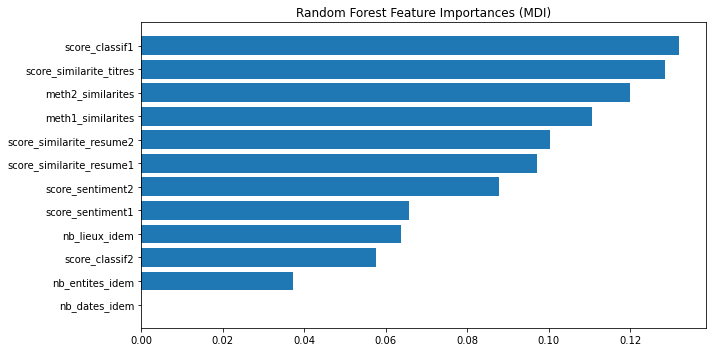

In [59]:
import matplotlib
import matplotlib.pyplot as plt
tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(predicteurs))
fig, ax = plt.subplots(figsize = (10,5))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(np.array(predicteurs)[sorted_idx])
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

In [72]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(Xtrain[:50],ytrain[:50])
res_lda = lda.predict(Xtrain[50:])
res_final = pd.concat([res_rf[['Overall','RF']],pd.DataFrame(res_lda,columns = ['LDA'],index = range(50,69))],axis=1)
res_final

,Overall,RF,LDA
50,1,1,2
51,1,1,1
52,4,3,3
53,1,4,1
54,1,2,3
55,2,2,3
56,2,4,3
57,4,4,3
58,2,1,1
59,2,4,3


In [73]:
from numpy import around
import numpy
np.set_printoptions(suppress=True)  # supprime notation exp
res_lda2 = around(lda.predict_proba(Xtrain[50:])*100, decimals=2)
res_lda2

array([[  6.96,  91.76,   1.28,   0.01],
       [100.  ,   0.  ,   0.  ,   0.  ],
       [  0.  ,  29.61,  35.34,  35.05],
       [ 57.3 ,   0.25,   0.26,  42.19],
       [ 14.64,  40.2 ,  41.63,   3.53],
       [  0.  ,  38.36,  51.99,   9.65],
       [  0.34,  16.88,  71.01,  11.77],
       [  0.  ,  41.09,  43.95,  14.96],
       [ 35.43,  28.85,  34.27,   1.45],
       [  0.  ,  19.77,  46.84,  33.39],
       [  0.  ,  50.83,  46.97,   2.2 ],
       [ 99.26,   0.16,   0.47,   0.1 ],
       [  0.05,  54.95,  44.99,   0.  ],
       [  0.  ,  33.09,  59.88,   7.04],
       [  0.  ,  20.58,  30.76,  48.66],
       [  0.  ,  12.57,  27.79,  59.63],
       [ 19.62,  57.28,  21.57,   1.52],
       [  0.  ,   1.66,   9.86,  88.48],
       [  0.01,   9.7 ,  49.91,  40.39]])

**_Remarquer que la classification ne tient pas compte du fait que c'est ordonné en classement 1-2-3-4 : ce qui est TRES important (ex : ligne 55% de 1 - 43% de 4) !! : il faudrait donc faire ressortir un score avec les probas plutot !!!_**

In [74]:
res_rf2 = around(rf.predict_proba(Xtrain[50:])*100, decimals=2)
res_rf2

array([[41., 27., 30.,  2.],
       [48., 15., 23., 14.],
       [ 3., 31., 40., 26.],
       [31., 23.,  8., 38.],
       [31., 42., 16., 11.],
       [ 6., 63., 11., 20.],
       [ 4., 28., 33., 35.],
       [ 1.,  7., 45., 47.],
       [36., 24., 35.,  5.],
       [ 0., 14., 30., 56.],
       [ 4., 43., 41., 12.],
       [62., 10., 17., 11.],
       [26., 32., 26., 16.],
       [ 4., 36., 52.,  8.],
       [ 7., 24., 26., 43.],
       [ 5., 32., 38., 25.],
       [33., 40., 24.,  3.],
       [ 0., 11., 20., 69.],
       [13., 27., 35., 25.]])

In [75]:
# Nouveau programme basé sur les scores probas : si plus de 50% mettre catégorie obtenue sinon, faire la somme 1-2 et 3/4 
# et prendre le plus gros score puis regarder si ce sore > 65% alors à ce moment là prendre le plus gros de la catégorie 
# sinon prendre 2 ou 3
def choix_classes(score_prob):
    classe_finale = []
    for i in range(len(score_prob)):
        res = list(score_prob[i,:])
        max_res = max(res)
        if max_res > 50:
            classe_finale.append(res.index(max_res)+1)
        else:
            som1 = res[0]+res[1]
            som2 = res[2]+res[3]
            if som1 > som2:
                if som1 >= 65:
                    choix = 1 if res[0]>res[1] else 2
                else:
                    choix = 2
            else:
                if som2 >= 65:
                    choix = 4 if res[3]>res[2] else 3
                else:
                    choix = 3
            classe_finale.append(choix)
    return classe_finale

In [76]:
liste_rf = choix_classes(res_rf2)
liste_lda = choix_classes(res_lda2)
res_final = pd.concat([res_final,pd.DataFrame(liste_lda,columns = ['LDA_Prob'],index = range(50,69)),
                       pd.DataFrame(liste_rf,columns = ['RF_Prob'],index = range(50,69))],axis=1)

In [77]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(Xtrain[:50],ytrain[:50])
res_knn = knn.predict(Xtrain[50:])
liste_knn = choix_classes(around(knn.predict_proba(Xtrain[50:])*100, decimals=2))
res_final = pd.concat([res_final,pd.DataFrame(res_knn,columns = ['KNN'],index = range(50,69)),
                      pd.DataFrame(liste_knn,columns = ['KNN_Prob'],index = range(50,69))],axis=1)

In [78]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(Xtrain[:50],ytrain[:50])
res_logreg = logreg.predict(Xtrain[50:])
liste_logreg = choix_classes(around(logreg.predict_proba(Xtrain[50:])*100, decimals=2))
res_final = pd.concat([res_final,pd.DataFrame(res_logreg,columns = ['LOGR'],index = range(50,69)),
                      pd.DataFrame(liste_knn,columns = ['LOGR_Prob'],index = range(50,69))],axis=1)

In [79]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(Xtrain[:50],ytrain[:50])
res_ada = ada.predict(Xtrain[50:])
liste_ada = choix_classes(around(ada.predict_proba(Xtrain[50:])*100, decimals=2))
res_final = pd.concat([res_final,pd.DataFrame(res_knn,columns = ['ADA'],index = range(50,69)),
                      pd.DataFrame(liste_knn,columns = ['ADA_Prob'],index = range(50,69))],axis=1)
res_final = res_final [['Overall','RF','LDA','KNN','LOGR','ADA','RF_Prob','LDA_Prob','KNN_Prob','LOGR_Prob','ADA_Prob']]

In [80]:
res_final

,Overall,RF,LDA,KNN,LOGR,ADA,RF_Prob,LDA_Prob,KNN_Prob,LOGR_Prob,ADA_Prob
50,1,1,2,2,1,2,1,2,2,2,2
51,1,1,1,3,1,3,2,1,3,3,3
52,4,3,3,2,2,2,3,3,3,3,3
53,1,4,1,1,1,1,2,1,1,1,1
54,1,2,3,1,2,1,2,2,2,2,2
55,2,2,3,2,2,2,2,3,3,3,3
56,2,4,3,4,3,4,4,3,4,4,4
57,4,4,3,4,3,4,4,3,4,4,4
58,2,1,1,2,2,2,2,2,2,2,2
59,2,4,3,3,4,3,4,3,3,3,3


Voir ensuite à utiliser les resultats reçus pour obtenir un resultat final : mieux ??

## REGRESSION Sklearn Pycaret

In [95]:
from pycaret.regression import *
from sklearn.linear_model import LinearRegression
francais = pd.read_csv('corpus_fr_notes.csv',index_col=0)
francais = francais[francais.meth1_similarites!='Error']
french_classif = setup(data = francais[predicteurs + ['Overall']],  target = 'Overall', html=False, silent=True, verbose=False)

In [96]:
lr = create_model('lr')
rr = create_model('lasso')
etr = create_model('et')
svr = create_model('svm')
adar = create_model('ada')
mlpr = create_model('mlp')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.7741,0.9496,0.9745,-2.9566,0.2968,0.2380
1,0.6085,0.4427,0.6654,0.2094,0.2201,0.3617
2,0.7360,0.6338,0.7961,0.2078,0.3253,0.4529
3,0.5847,0.5855,0.7652,0.2681,0.2096,0.2599
4,0.8956,1.0115,1.0057,-0.8063,0.2527,0.2599
5,1.1116,1.3586,1.1656,0.2616,0.3817,0.7350
6,0.7928,1.0261,1.0130,0.2455,0.2791,0.3279
7,1.0283,1.4605,1.2085,-1.6081,0.3836,0.6925
8,0.8877,1.6309,1.2771,0.0336,0.4169,0.7739
9,0.8531,1.3986,1.1826,-1.0344,0.4347,0.3814


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.6809,0.6558,0.8098,-1.7326,0.2126,0.1969
1,0.7289,0.7609,0.8723,-0.3587,0.2996,0.5035
2,0.3455,0.2134,0.4620,0.7332,0.1536,0.2214
3,0.8249,0.8184,0.9047,-0.0230,0.2374,0.3254
4,0.6574,0.8187,0.9048,-0.4619,0.2139,0.1773
5,0.9655,1.0765,1.0375,0.4150,0.3170,0.5435
6,0.9742,1.1829,1.0876,0.1302,0.3175,0.4879
7,0.7142,0.7068,0.8407,-0.2622,0.2900,0.4690
8,0.8893,1.1285,1.0623,0.3313,0.3636,0.6802
9,0.6460,0.7010,0.8372,-0.0196,0.2709,0.2948


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4760,0.4971,0.7050,-1.0712,0.1949,0.1413
1,0.8040,0.8367,0.9147,-0.4941,0.3004,0.5150
2,0.4120,0.3027,0.5502,0.6216,0.1645,0.2320
3,0.8500,0.8574,0.9260,-0.0718,0.2450,0.3382
4,1.1320,2.0218,1.4219,-2.6104,0.3794,0.3243
5,0.7480,0.7062,0.8404,0.6162,0.2612,0.4300
6,1.2060,2.1693,1.4729,-0.5951,0.4377,0.5395
7,0.9440,1.3534,1.1634,-1.4169,0.3728,0.6107
8,0.5875,0.4635,0.6808,0.7253,0.2452,0.4133
9,0.7575,0.8009,0.8949,-0.1649,0.2921,0.3904


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.6943,0.7501,0.8661,-2.1253,0.2310,0.1991
1,0.5486,0.5773,0.7598,-0.0309,0.2722,0.4172
2,0.3292,0.1713,0.4139,0.7859,0.1332,0.1992
3,0.8556,0.7837,0.8852,0.0204,0.2298,0.3221
4,0.6266,0.8736,0.9347,-0.5600,0.2217,0.1603
5,0.8541,0.9852,0.9926,0.4646,0.2777,0.4042
6,0.8499,1.0026,1.0013,0.2628,0.2769,0.3727
7,0.6788,0.7283,0.8534,-0.3005,0.2930,0.4298
8,0.8045,0.9033,0.9504,0.4647,0.3268,0.5912
9,0.6055,0.6138,0.7835,0.1072,0.2508,0.2855


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4833,0.3792,0.6158,-0.5799,0.1576,0.1389
1,0.9898,1.0885,1.0433,-0.9437,0.3304,0.6002
2,0.4042,0.2700,0.5196,0.6626,0.1691,0.2642
3,0.9145,0.8585,0.9266,-0.0732,0.2424,0.3453
4,0.9886,1.5795,1.2568,-1.8206,0.3266,0.2868
5,0.8578,0.8692,0.9323,0.5276,0.3095,0.5533
6,1.3422,2.4099,1.5524,-0.7720,0.4590,0.7089
7,0.7856,0.9600,0.9798,-0.7143,0.3332,0.4553
8,0.6508,0.6525,0.8078,0.6133,0.2743,0.4450
9,0.5706,0.4625,0.6801,0.3273,0.2014,0.2651


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.2032,8.0222,2.8323,-32.4257,0.4694,0.6833
1,2.5357,10.2582,3.2028,-17.3181,0.7458,1.7978
2,2.6617,9.8158,3.1330,-11.2698,0.7183,1.7039
3,2.1170,5.7157,2.3907,-6.1446,0.6683,0.7954
4,2.0644,6.9507,2.6364,-11.4120,0.5057,0.7838
5,1.6205,4.8418,2.2004,-1.6314,0.6047,1.3561
6,3.0986,22.0949,4.7005,-15.2462,0.8951,2.3708
7,2.1007,4.9239,2.2190,-7.7927,0.5886,1.2917
8,5.3286,51.7128,7.1912,-29.6446,1.2716,5.1045
9,3.1139,14.7283,3.8377,-20.4229,0.8278,2.2467


In [97]:
# Linear Regression simple sur scikit learn
essai_classif = francais[['Geography','Entities', 'Time', 'Narrative', 'Overall', 'Style', 'Tone','nb_entites_idem', 
    'nb_lieux_idem', 'nb_dates_idem', 'score_similarite_titres', 'score_similarite_resume1','score_similarite_resume2', 
    'score_classif1', 'score_classif2','score_sentiment1', 'score_sentiment2', 'meth1_similarites','meth2_similarites']]
lr = LinearRegression()
Xtrain = essai_classif[predicteurs].reset_index(drop=True)
ytrain = essai_classif['Overall'].reset_index(drop=True)

In [98]:
lr.fit(Xtrain[:50],ytrain[:50])
res_lr = lr.predict(Xtrain[50:])
res_lr = pd.concat([Xtrain[50:],ytrain[50:],pd.DataFrame(res_lr,columns = ['LR'],index = range(50,69))],axis=1)
res_lr

,nb_entites_idem,nb_lieux_idem,nb_dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,meth1_similarites,meth2_similarites,Overall,LR
50,6,8,0,99.54,9.49,14.58,79.42,9.45,95.91,41.50,256.4,301.4,1.0,0.599858
51,0,13,0,81.60,36.71,24.86,97.61,8.36,96.46,11.05,165.4,389.4,1.0,0.578922
52,0,0,0,0.56,0.70,0.73,4.73,8.62,99.99,32.26,80.7,215.1,4.0,3.222043
53,4,0,0,0.12,81.61,11.23,66.44,10.38,97.21,16.85,564.1,248.6,1.0,2.897480
54,1,3,0,0.52,1.27,0.58,46.37,8.59,83.60,30.36,374.8,339.8,1.0,1.929214
55,1,0,0,0.33,8.41,0.59,32.87,10.75,18.59,33.70,130.0,159.8,2.0,2.748877
56,0,3,0,0.75,0.11,1.40,44.72,9.49,7.46,28.30,138.8,74.0,2.0,2.529084
57,0,0,0,7.73,2.12,4.33,10.34,10.07,99.87,46.52,21.1,54.1,4.0,3.034551
58,0,4,0,5.24,10.72,2.12,81.74,11.49,99.90,34.50,223.8,170.8,2.0,1.758119
59,0,0,0,0.23,0.74,0.27,3.77,13.04,91.10,36.71,50.7,68.7,2.0,3.645473


In [99]:
res_final = pd.concat([res_final,res_lr['LR']],axis=1)

remarque : les résultats sont assez différents : voir à utiliser différents algos ? <br/>
En classification : Logistic Regression - XG Boost ?? - Linear Discriminant Analysis qui était OK en essai - Bayésien ? ADA Boost ? SVM ? : 1 score de classif en utilisant proba <br/>
puis un score de régression : la Régression PLS peut être intéressante car les notes doivent très corrélées entre elles - Lasso ou ridge ne servent à rien a priori - SVR - RDN ?

In [100]:
from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression()
pls.fit(Xtrain[:50],ytrain[:50])
res_pls = list(pls.predict(Xtrain[50:]).flatten())
res_pls = pd.concat([res_lr,pd.DataFrame(res_pls,columns = ['PLS'],index = range(50,69))],axis=1)
res_pls

,nb_entites_idem,nb_lieux_idem,nb_dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,meth1_similarites,meth2_similarites,Overall,LR,PLS
50,6,8,0,99.54,9.49,14.58,79.42,9.45,95.91,41.50,256.4,301.4,1.0,0.599858,0.762088
51,0,13,0,81.60,36.71,24.86,97.61,8.36,96.46,11.05,165.4,389.4,1.0,0.578922,0.670705
52,0,0,0,0.56,0.70,0.73,4.73,8.62,99.99,32.26,80.7,215.1,4.0,3.222043,3.041758
53,4,0,0,0.12,81.61,11.23,66.44,10.38,97.21,16.85,564.1,248.6,1.0,2.897480,2.537666
54,1,3,0,0.52,1.27,0.58,46.37,8.59,83.60,30.36,374.8,339.8,1.0,1.929214,1.842386
55,1,0,0,0.33,8.41,0.59,32.87,10.75,18.59,33.70,130.0,159.8,2.0,2.748877,2.877619
56,0,3,0,0.75,0.11,1.40,44.72,9.49,7.46,28.30,138.8,74.0,2.0,2.529084,2.728216
57,0,0,0,7.73,2.12,4.33,10.34,10.07,99.87,46.52,21.1,54.1,4.0,3.034551,3.115408
58,0,4,0,5.24,10.72,2.12,81.74,11.49,99.90,34.50,223.8,170.8,2.0,1.758119,2.026156
59,0,0,0,0.23,0.74,0.27,3.77,13.04,91.10,36.71,50.7,68.7,2.0,3.645473,3.820556


les scores de la regression PLS sont assez proches de la régression linéaire !

In [101]:
res_final = pd.concat([res_final,res_pls['PLS']],axis=1)
res_final

,Overall,RF,LDA,KNN,LOGR,ADA,RF_Prob,LDA_Prob,KNN_Prob,LOGR_Prob,ADA_Prob,LR,PLS
50,1,1,2,2,1,2,1,2,2,2,2,0.599858,0.762088
51,1,1,1,3,1,3,2,1,3,3,3,0.578922,0.670705
52,4,3,3,2,2,2,3,3,3,3,3,3.222043,3.041758
53,1,4,1,1,1,1,2,1,1,1,1,2.897480,2.537666
54,1,2,3,1,2,1,2,2,2,2,2,1.929214,1.842386
55,2,2,3,2,2,2,2,3,3,3,3,2.748877,2.877619
56,2,4,3,4,3,4,4,3,4,4,4,2.529084,2.728216
57,4,4,3,4,3,4,4,3,4,4,4,3.034551,3.115408
58,2,1,1,2,2,2,2,2,2,2,2,1.758119,2.026156
59,2,4,3,3,4,3,4,3,3,3,3,3.645473,3.820556


**Compléments d'information**

In [ ]:
visuel = francais[['title_1', 'title_2','summary1_text1', 'summary2_text1', 'summary1_text2', 'summary2_text2',
    'nb_entites_idem', 'nb_lieux_idem', 'nb_dates_idem', 'entites_idem','dates_idem', 'score_similarite_titres',
    'score_similarite_resume1', 'score_similarite_resume2','score_classif1', 'score_classif2', 'score_sentiment1',
    'score_sentiment2', 'meth1_similarites', 'meth2_similarites','Overall']]
visuel

In [61]:
data.columns

Index(['pair_id', 'pair_lang', 'source_url_1', 'publish_date_1',
       'source_url_2', 'publish_date_2', 'title_1', 'text_1',
       'meta_description_1', 'meta_keywords_1', 'title_2', 'text_2',
       'meta_description_2', 'meta_keywords_2', 'Geography', 'Entities',
       'Time', 'Narrative', 'Overall', 'Style', 'Tone', 'ligne'],
      dtype='object')

In [67]:
comp_francais = data.loc[data.pair_lang == 'fr_fr',['source_url_1', 'publish_date_1','source_url_2', 'publish_date_2', 
       'meta_description_1', 'meta_keywords_1', 'meta_description_2', 'meta_keywords_2','Overall']].reset_index(drop=True)

In [68]:
comp_francais

,source_url_1,publish_date_1,source_url_2,publish_date_2,meta_description_1,meta_keywords_1,meta_description_2,meta_keywords_2,Overall
0,https://votreargent.lexpress.fr,Wed Mar 25 20:11:35 2020,https://www.lexpress.fr,Wed Mar 25 07:00:00 2020,Le cap du million de ventes a été dépassé l'an...,[''],"Stocks réduits ou distribués au ""compte-goutte...",[''],3.0
1,https://www.coupdoeil.info,Wed Mar 25 00:00:00 2020,http://www.lechodelaval.ca,,,[''],,[''],4.0
2,http://ici.radio-canada.ca,,https://www.lapresse.ca,Wed Mar 25 05:00:00 2020,,[''],Des Québécois coincés au Pérou qualifient de «...,[''],2.0
3,http://beninsite.net,Wed Mar 25 00:00:00 2020,http://www.togolais.info,,,[''],"En l'espace de quelques jours, deux piliers de...","[""L'Afrique pleure Manu Dibango"", '', 'info', ...",1.0
4,https://www.lareleve.qc.ca,Wed Mar 25 00:00:00 2020,https://canadianwomen.org,Wed Mar 25 21:15:26 2020,La MRC a décidé de mettre de l’avant différent...,[''],,[''],3.0
...,...,...,...,...,...,...,...,...,...
67,https://www.bladi.net,,https://www.bladi.net,,Les forces de l’ordre effectuent des inspectio...,[''],Suite aux violations du confinement dans les v...,[''],3.0
68,http://ici.radio-canada.ca,,https://www.journalexpress.ca,Wed May 27 00:00:00 2020,,[''],,[''],3.0
69,http://fr.nhandan.com.vn,,http://fr.nhandan.com.vn,,"Nhân Dân en ligne - Asiatoday, l'un des princi...","['Le journal Nhân Dân', 'politique', 'économie...",Nhân Dân en ligne - Le Premier ministre (PM) v...,"['Le journal Nhân Dân', 'politique', 'économie...",1.0
70,https://www.acadienouvelle.com,Thu Jun 11 00:00:00 2020,https://www.telecablesat.fr,,Muriel Roy nous a quittés dans sa 100e année. ...,['Acadie'],Comment avez-vous vécu le confinement?Au début...,[''],4.0
